In [1]:
#ref - https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import math
import scipy
import scipy.sparse
import pickle
import os
print('CWD is ',os.getcwd())

import pandas as pd
import numpy as np

# Vis Libs..
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Libs..
import re
from gensim import corpora, models
import gensim
from tqdm import tqdm,tqdm_notebook
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# ML Libs...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

CWD is  /Users/jaslyn/Documents/FYP/mercari-price-suggestion-challenge


In [2]:
df_train = pd.read_csv('train.tsv', '\t')
df_train_split ,df_test_split = train_test_split(df_train,test_size = 0.25)

# Missing Data

After conducting an EDA on our dataset, we observed that name and category_name has missing data.  
We will fill the missing data with "Missing"

In [3]:
def fill_missing_data(data):
    data.brand_name.fillna(value = "Missing", inplace = True)
    data.category_name.fillna(value = "Missing", inplace = True)

fill_missing_data(df_train_split)
fill_missing_data(df_test_split)

In [4]:
df_train_split['item_description'] = df_train_split['item_description'].replace([np.nan],"Missing")
df_test_split['item_description'] = df_test_split['item_description'].replace([np.nan],"Missing")

In [5]:
df_train_split[df_train_split == 'Missing'].count()

train_id                  0
name                      0
item_condition_id         0
category_name          4758
brand_name           474553
price                     0
shipping                  0
item_description          2
dtype: int64

# Remove outliers in Price Column

In [6]:
df_train_split[df_train_split["price"] < 3].count()

train_id             625
name                 625
item_condition_id    625
category_name        625
brand_name           625
price                625
shipping             625
item_description     625
dtype: int64

In [7]:
df_train_split[df_train_split["price"] > 2000].count()

train_id             2
name                 2
item_condition_id    2
category_name        2
brand_name           2
price                2
shipping             2
item_description     2
dtype: int64

The minimum price in Mercari is 3. therefore we will filter out the items with prices >= 3.

In [8]:
df_train_split = df_train_split[(df_train_split.price >= 3)]
df_test_split = df_test_split[(df_test_split.price >= 3)]

In [9]:
df_train_split = df_train_split[(df_train_split.price < 2000 )]
df_test_split = df_test_split[(df_test_split.price < 2000 )]

In [10]:
df_train_split['price'].describe().apply(lambda x: format(x, 'f'))

count    1111268.000000
mean          26.751634
std           38.380477
min            3.000000
25%           10.000000
50%           17.000000
75%           29.000000
max         1999.000000
Name: price, dtype: object

Log(Price). We applied log to the price as based on our EDA, we found that prices are skewed. 

In [11]:
df_train_split['log_price'] = np.log1p(df_train_split['price'])
df_test_split['log_price'] = np.log1p(df_test_split['price'])

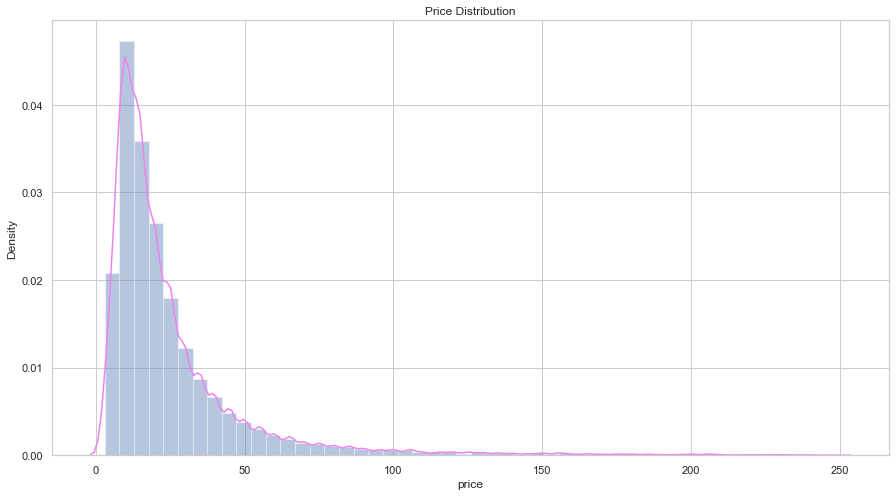

In [12]:
a = df_train_split[df_train_split['price'] < 250]['price']
sns.set(rc={'figure.figsize':(15,8)}, style = 'whitegrid')
sns.distplot( a , kde_kws = {"color" : "violet"})
plt.title('Price Distribution')
plt.show()

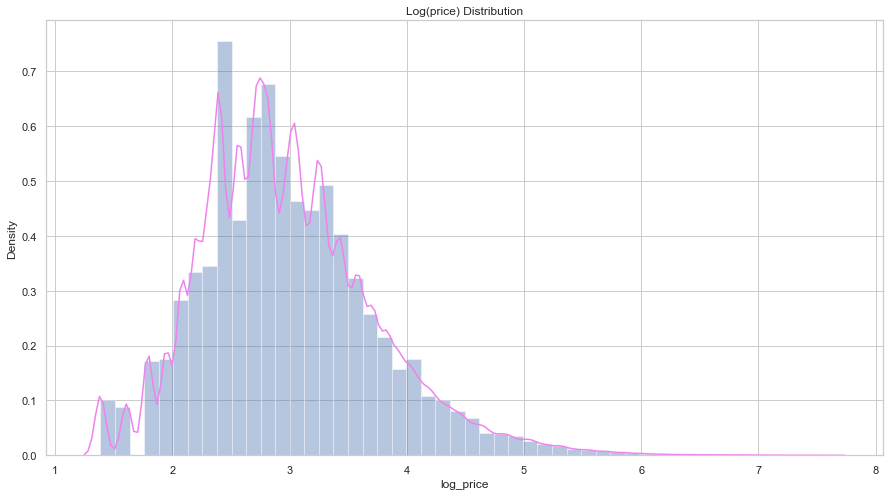

In [13]:
sns.set(rc={'figure.figsize':(15,8)}, style = 'whitegrid')
sns.distplot(df_train_split['log_price'], kde_kws = {"color" : "violet"})
plt.title('Log(price) Distribution')
plt.show()

# Tokenize

Count vectorizer: The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

## Category_name column

In [14]:
cat_unique = pd.Series("/".join(df_train_split["category_name"].unique().astype("str")).split("/")).unique()

In [15]:
print(len(cat_unique))

937


In [16]:
CV_category = CountVectorizer(vocabulary = cat_unique ,lowercase = False, binary = True)

In [17]:
CV_category.fit(df_train_split["category_name"])
df_train_transform = CV_category.transform(df_train_split["category_name"])
df_test_transform = CV_category.transform(df_test_split['category_name'])

#creates a matrix in which each unique word is represented by a column of the matrix,
#and each text sample from the document is a row in the matrix. 
#The value of each cell is nothing but the count of the word in that particular text sample. 
print(df_train_transform.shape, df_test_transform.shape)

(1111268, 937) (370384, 937)


In [18]:
CV_category.get_feature_names()

['Women',
 'Dresses',
 'Above Knee, Mini',
 'Electronics',
 'TV, Audio & Surveillance',
 'Headphones',
 'Other',
 'Books',
 'Education & Teaching',
 'Men',
 'Sweats & Hoodies',
 'Sweatshirt, Pullover',
 'Jewelry',
 'Earrings',
 'Vintage & Collectibles',
 'Antique',
 'Book',
 'Beauty',
 'Bath & Body',
 'Scrubs & Body Treatments',
 'Cell Phones & Accessories',
 'Cables & Adapters',
 'Shoes',
 'Fashion Sneakers',
 'Kids',
 'Girls 2T-5T',
 'Tops & T-Shirts',
 'Athletic',
 'Makeup',
 'Makeup Palettes',
 'Tops & Blouses',
 'Blouse',
 'Athletic Apparel',
 'Pants',
 'Accessories',
 'Gloves',
 'Face',
 'T-Shirts',
 "Women's Handbags",
 'Totes & Shoppers',
 'Boots',
 'Shoulder Bag',
 'Cargo',
 'Cases, Covers & Skins',
 'Underwear',
 'Bras',
 'Polo Shirt',
 'Handmade',
 'Music',
 'Vinyl',
 'Bracelets',
 'Knee-Length',
 'Knit Top',
 'Skin Care',
 'Jeans',
 'Leggings',
 'Media',
 'Blu-Ray',
 'Housewares',
 'Wall Decor',
 'Khakis, Chinos',
 'Toys',
 'Dolls & Accessories',
 'Panties',
 'Halter',
 'Sh

In [19]:
df_train_transform.toarray()

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
CV_category.vocabulary_

{'Women': 0,
 'Dresses': 1,
 'Above Knee, Mini': 2,
 'Electronics': 3,
 'TV, Audio & Surveillance': 4,
 'Headphones': 5,
 'Other': 6,
 'Books': 7,
 'Education & Teaching': 8,
 'Men': 9,
 'Sweats & Hoodies': 10,
 'Sweatshirt, Pullover': 11,
 'Jewelry': 12,
 'Earrings': 13,
 'Vintage & Collectibles': 14,
 'Antique': 15,
 'Book': 16,
 'Beauty': 17,
 'Bath & Body': 18,
 'Scrubs & Body Treatments': 19,
 'Cell Phones & Accessories': 20,
 'Cables & Adapters': 21,
 'Shoes': 22,
 'Fashion Sneakers': 23,
 'Kids': 24,
 'Girls 2T-5T': 25,
 'Tops & T-Shirts': 26,
 'Athletic': 27,
 'Makeup': 28,
 'Makeup Palettes': 29,
 'Tops & Blouses': 30,
 'Blouse': 31,
 'Athletic Apparel': 32,
 'Pants': 33,
 'Accessories': 34,
 'Gloves': 35,
 'Face': 36,
 'T-Shirts': 37,
 "Women's Handbags": 38,
 'Totes & Shoppers': 39,
 'Boots': 40,
 'Shoulder Bag': 41,
 'Cargo': 42,
 'Cases, Covers & Skins': 43,
 'Underwear': 44,
 'Bras': 45,
 'Polo Shirt': 46,
 'Handmade': 47,
 'Music': 48,
 'Vinyl': 49,
 'Bracelets': 50,
 'K

Truncated SVD for feature importance & dimensionality reduction

What is SVD?
SVD for short, is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler.

It helps with dimensionality reduction.

(In progress - need to figure out how to extract these identified features)



In [21]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200, n_iter=1)
svd.fit(df_train_transform)

TruncatedSVD(n_components=200, n_iter=1)

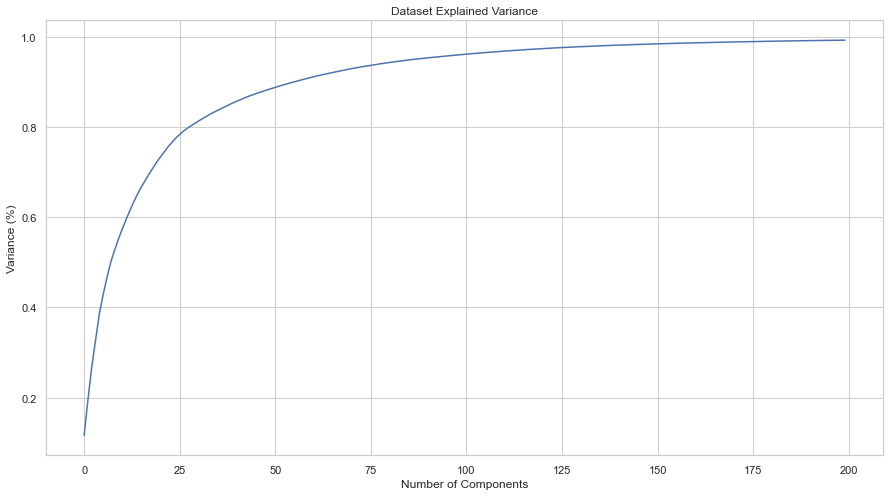

In [22]:
plt.figure()
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

In [23]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, n_iter=1)
svd.fit(df_train_transform)

TruncatedSVD(n_components=100, n_iter=1)

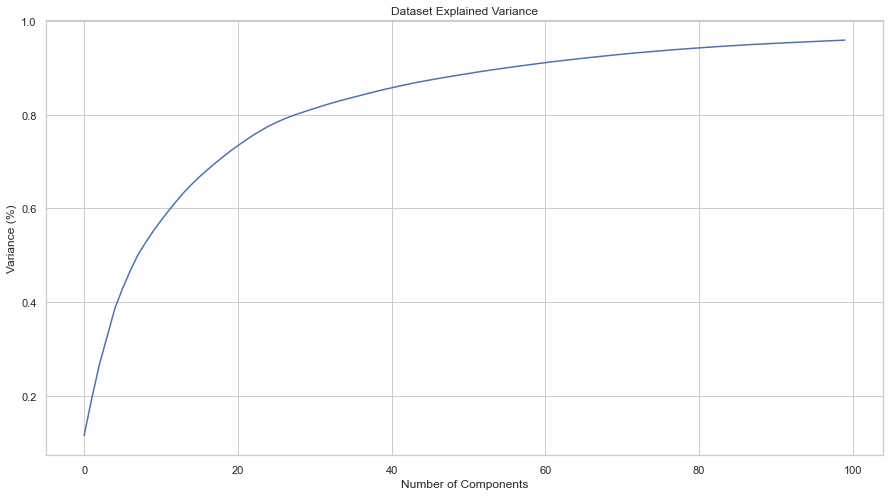

In [24]:
plt.figure()
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

with K = 80, we get an explained variance above 90%(?).Hence, 80 features or words explain 90% of our data.

We can just use these top components as our features.

## Name column

In [25]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
stop_words = stopwords.words('english')

def preprocess(sentence):
    sentence=str(sentence).lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stop_words]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(lemma_words)

df_train_split['name_process']=df_train_split['name'].map(lambda s:preprocess(s))
df_test_split['name_process']=df_test_split['name'].map(lambda s:preprocess(s))


In [26]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(df_train_split['name_process'].values) 


train_name = vectorizer.transform(df_train_split['name_process'].values)
test_name = vectorizer.transform(df_test_split['name_process'].values)

print("After vectorizations")
print(train_name.shape)

print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(1111268, 11656)
['aaa', 'aaliyah', 'aaron', 'ab', 'abalon', 'abaya', 'abbey', 'abbi', 'abc', 'abercombi', 'abercrombi', 'abh', 'abigail', 'abl', 'abomin', 'abraham', 'absolu', 'absolut', 'absorb', 'abstract', 'abu', 'abund', 'acacia', 'academ', 'academi', 'acai', 'acc', 'acceler', 'accent', 'accept', 'accesori', 'access', 'accessori', 'accordion', 'accu', 'acdc', 'ace', 'acer', 'acg', 'acid', 'acm', 'acn', 'aconcagua', 'acorn', 'acoust', 'acqua', 'acryl', 'act', 'action', 'activ', 'activewear', 'actual', 'acu', 'acut', 'acuvu', 'ad', 'ada', 'adair', 'adam', 'adapt', 'adaptor', 'add', 'addam', 'addi', 'addia', 'addict', 'addida', 'addison', 'addit', 'address', 'ade', 'adel', 'adelin', 'aden', 'adhd', 'adhes', 'adi', 'adida', 'adidia', 'adidog', 'adirondack', 'adizero', 'adjust', 'admir', 'adob', 'adopt', 'ador', 'adrenalin', 'adrian', 'adriana', 'adrianna', 'adriano', 'adrienn', 'adt', 'adult', 'adv', 'advanc', 'advantag', 'advantix', 'advent', 'adventur', 'advisor

# Item Description

In [27]:
# function to decontract phrases
#https://stackoverflow.com/questions/43018030/replace-apostrophe-short-words-in-python
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def text_process(text):
    stop_words = stopwords.words('english')
    processed = []
    desc_length_tokenized = []
    for sentence in tqdm_notebook(text):
        sentence = sentence.lower()
        sentence_decontracted = decontracted(sentence)
        sentence_decontracted = sentence_decontracted.replace('\\"', ' ')
        sentence_decontracted = sentence_decontracted.replace('\\`', ' ')
        sentence_decontracted = re.sub(r"[^0-9a-zA-Z]+", ' ', sentence_decontracted)
        text_tokens = word_tokenize(sentence_decontracted)
        desc_length_tokenized.append(len(text_tokens))
        joined_words = " ".join(word for word in text_tokens if word not in stop_words)
        processed.append(joined_words)
    return processed, desc_length_tokenized

In [28]:
df_train_split['item_description'] = df_train_split['item_description'].replace([np.nan],"Missing")
df_test_split['item_description'] = df_test_split['item_description'].replace([np.nan],"Missing")

Creating item description length

In [29]:
df_train_split['item_desc_processed'], df_train_split['item_desc_length_tokenized'] = text_process(df_train_split['item_description'])
df_test_split['item_desc_processed'], df_test_split['item_desc_length_tokenized'] = text_process(df_test_split['item_description'])

In [30]:
df_train_split['item_desc_processed_2']=df_train_split['item_description'].map(lambda s:preprocess(s))
df_test_split['item_desc_processed_2']=df_test_split['item_description'].map(lambda s:preprocess(s))

In [31]:
def tokenizer(text):
    if text:
        result = re.findall('[a-z]{2,}', text.lower())
    else:
        result = []
    return result

tfidf_vectorizer=TfidfVectorizer(tokenizer=tokenizer, ngram_range=(1,3), min_df = 10, max_df = 0.5, max_features=5000, use_idf=True) 
tfidf_vectorizer_vectors_train = tfidf_vectorizer.fit_transform(df_train_split['item_desc_processed_2'])
tfidf_vectorizer_vectors_test = tfidf_vectorizer.transform(df_test_split['item_desc_processed_2'])


In [32]:
print(tfidf_vectorizer_vectors_train.shape)
print(tfidf_vectorizer_vectors_test.shape)

(1111268, 5000)
(370384, 5000)


In [33]:
print(tfidf_vectorizer.get_feature_names())

['abercrombi', 'abercrombi fitch', 'abh', 'abil', 'abl', 'absolut', 'absorb', 'accent', 'accept', 'accept offer', 'access', 'accessori', 'accident', 'accord', 'accordingli', 'account', 'accur', 'achiev', 'acid', 'acn', 'across', 'acryl', 'act', 'action', 'activ', 'activ charcoal', 'actual', 'ad', 'adapt', 'add', 'addict', 'addit', 'addit item', 'address', 'adhes', 'adhes seal', 'adida', 'adjust', 'adjust shoulder', 'adjust shoulder strap', 'adjust strap', 'ador', 'adult', 'advanc', 'advantag', 'adventur', 'aeropostal', 'affect', 'afford', 'african', 'age', 'ago', 'agre', 'air', 'air dri', 'air ipad', 'air jordan', 'air max', 'alarm', 'album', 'alcohol', 'alex', 'alex ani', 'alien', 'allergi', 'allow', 'alloy', 'almond', 'almost', 'almost new', 'alo', 'aloha', 'alon', 'along', 'alreadi', 'also', 'also avail', 'also come', 'also fit', 'also includ', 'also sell', 'also use', 'alter', 'altern', 'although', 'aluminum', 'alway', 'alway free', 'alway free ship', 'alway ship', 'amaz', 'amaz co

## Sentiment of item description

Our wordcloud in our EDA highlighted important words such as 'brand new', 'free', 'cute'. We want to see whether such descriptions will portray different sentiments to attract a buyer.

In [34]:
def generate_sentiment_scores(sentences):
    analyzer = SentimentIntensityAnalyzer()
    results = []
    for sentence in tqdm_notebook(sentences): 
        sentence_sentiment_score = analyzer.polarity_scores(sentence)
        results.append(sentence_sentiment_score)
    return results

In [35]:
train_senti_desc = generate_sentiment_scores(df_train_split['item_description'])
test_senti_desc = generate_sentiment_scores(df_test_split['item_description'])

In [36]:
def get_sentiments(dataframe, array):
    negative, neutral, compound, positive = [], [], [], []
    for sentiment_dict in array:
        for sentiment, score in sentiment_dict.items():
            if(sentiment=='neg'):
                negative.append(score)
            elif(sentiment=='neu'):
                neutral.append(score)
            elif(sentiment=='compound'):
                compound.append(score)
            elif(sentiment=='pos'):
                positive.append(score)
    dataframe['negative'] = negative
    dataframe['positive'] = positive
    dataframe['neutral'] = neutral
    dataframe['compound'] = compound

In [37]:
get_sentiments(df_train_split,train_senti_desc)
get_sentiments(df_test_split,test_senti_desc)

In [38]:
df_train_split

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,name_process,item_desc_processed,item_desc_length_tokenized,item_desc_processed_2,negative,positive,neutral,compound
1101238,1101238,Cold Shoulder Shift Dress (Blue & White),3,"Women/Dresses/Above Knee, Mini",Missing,10.0,0,"Very flattering dress, worn a few times. Size ...",2.397895,cold shoulder shift dress blue white,flattering dress worn times size large short s...,17,flatter dress worn time size larg short slip n...,0.135,0.208,0.657,0.0847
607620,607620,NEW Red Power Beats,1,"Electronics/TV, Audio & Surveillance/Headphones",Beats,86.0,0,"New in sealed package, power beats. Red color ...",4.465908,new red power beat,new sealed package power beats red color brand...,13,new seal packag power beat red color brand new...,0.000,0.000,1.000,0.0000
733024,733024,Bundle book and pants,2,Other/Books/Education & Teaching,Missing,6.0,1,Mint condition 207 pages nutrition book,1.945910,bundl book pant,mint condition 207 pages nutrition book,6,mint condit page nutrit book,0.000,0.000,1.000,0.0000
840932,840932,VS Pink Lavender Pullover,3,"Men/Sweats & Hoodies/Sweatshirt, Pullover",PINK,20.0,1,Size small lavender PINK pullover with pink lo...,3.044522,pink lavend pullov,size small lavender pink pullover pink logo ba...,12,size small lavend pink pullov pink logo back c...,0.000,0.261,0.739,0.5974
854753,854753,Yin-Yang Plugs,3,Women/Jewelry/Earrings,Missing,8.0,0,"size 2G, metal, and they screw on.",2.197225,yin yang plug,size 2g metal screw,7,size metal screw,0.189,0.000,0.811,-0.1027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078901,1078901,Reserved CrazyCL (2) 3Wick Island Colada,1,Beauty/Fragrance/Candles & Home Scents,Bath & Body Works,38.0,0,2 3 Wick Island Colada Candles Somebody bring ...,3.663562,reserv crazycl wick island colada,2 3 wick island colada candles somebody bring ...,22,wick island colada candl somebodi bring straw ...,0.000,0.315,0.685,0.8110
484752,484752,Ole Henriksen Lemon Face Peel,2,Beauty/Skin Care/Face,Sephora,30.0,1,Ole Henriksen lemon strip flash peel. Comes wi...,3.433987,ole henriksen lemon face peel,ole henriksen lemon strip flash peel comes bru...,20,ole henriksen lemon strip flash peel come brus...,0.000,0.000,1.000,0.0000
834908,834908,Halloween costume Angel Fairy. Size M,1,Handmade/Clothing/Costume,Missing,16.0,0,Includes dress with hoop hem. Halo on a headba...,2.833213,halloween costum angel fairi size,includes dress hoop hem halo headband two sets...,41,includ dress hoop hem halo headband two set wi...,0.097,0.137,0.766,0.4184
1261786,1261786,Ralph Lauren polo vneck,3,Women/Tops & Blouses/Polo Shirt,Polo Ralph Lauren,19.0,0,Worn once perfect condition,2.995732,ralph lauren polo vneck,worn perfect condition,4,worn perfect condit,0.278,0.468,0.253,0.3612


Our team also observed special characters in item descriptions, such as '#&*!' . Thus we consolidated the sum of such characters to create 'percentages'.

In [39]:
def get_description_features(dataframe, sentence_df):
    percentage_of_exclamation_marks, percentage_of_star, percentage_of_ampersand, percentage_of_hashtag = [], [], [], []
    for description in sentence_df:
        hashtag_regex = re.compile(r'(#[a-z]{2,})')
        percentage_of_exclamation_marks.append(description.count('!')/len(description) * 100)
        percentage_of_star.append(description.count("*")/len(description)*100)
        percentage_of_ampersand.append(description.count("%")/len(description)*100)
        percentage_of_hashtag.append(len(hashtag_regex.findall(description))/len(description)*100)
    dataframe['percentage_of_exclamation_marks'] = percentage_of_exclamation_marks
    dataframe['percentage_of_star'] = percentage_of_star
    dataframe['percentage_of_ampersand'] = percentage_of_ampersand
    dataframe['percentage_of_hashtag'] = percentage_of_hashtag

In [40]:
get_description_features(df_train_split,df_train_split['item_description'])
get_description_features(df_test_split,df_test_split['item_description'])

In [41]:
df_train_split.describe()

,train_id,item_condition_id,price,shipping,log_price,item_desc_length_tokenized,negative,positive,neutral,compound,percentage_of_exclamation_marks,percentage_of_star,percentage_of_ampersand,percentage_of_hashtag
count,1.111268e+06,1.111268e+06,1.111268e+06,1.111268e+06,1.111268e+06,1.111268e+06,1.111268e+06,1.111268e+06,1.111268e+06,1.111268e+06,1.111268e+06,1.111268e+06,1.111268e+06,1.111268e+06
mean,7.411656e+05,1.907327e+00,2.675163e+01,4.466330e-01,2.981160e+00,2.591059e+01,7.000119e-02,1.627722e-01,7.670089e-01,3.239697e-01,4.357017e-01,9.281922e-02,3.868886e-02,1.084794e-02
std,4.279436e+05,9.032919e-01,3.838048e+01,4.971440e-01,7.457667e-01,3.046296e+01,1.390893e-01,1.714035e-01,1.935702e-01,4.363092e-01,1.450587e+00,7.418280e-01,2.746969e-01,2.194603e-01
min,0.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,1.386294e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.958000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.707488e+05,1.000000e+00,1.000000e+01,0.000000e+00,2.397895e+00,7.000000e+00,0.000000e+00,0.000000e+00,6.410000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.410935e+05,2.000000e+00,1.700000e+01,0.000000e+00,2.890372e+00,1.500000e+01,0.000000e+00,1.370000e-01,7.840000e-01,3.612000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.111680e+06,3.000000e+00,2.900000e+01,1.000000e+00,3.401197e+00,3.100000e+01,7.800000e-02,2.640000e-01,9.560000e-01,7.269000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.482534e+06,5.000000e+00,1.999000e+03,1.000000e+00,7.600902e+00,2.690000e+02,1.000000e+00,1.000000e+00,1.000000e+00,9.989000e-01,1.000000e+02,1.000000e+02,1.666667e+01,2.500000e+01


# Cat Brand Shipping

Group by category, brand and shipping.

Intial research showed that shipping is an important factor in affecting how a brand set prices. 
Therefore, by grouping the category, brand and shipping, we can aggregate prices to create new features that will show us how cat brand and shipping can be useful in predicting prices.

In [42]:
def generate_cbs_stats(train_data, test_data_to_transform):
    df_group_cat_brand_shipping = train_data.groupby('cat_brand_ship',as_index = False).agg({"shipping" : len,
                                                        "log_price" : [np.median, np.mean, np.std,np.min,np.max]})
    df_group_cat_brand_shipping.columns = ['cat_brand_ship','cat_brand_shipping_count','cat_brand_shipping_log_price_median','cat_brand_shipping_log_price_mean','cat_brand_shipping_log_price_std',
                    'cat_brand_shipping_log_price_min','cat_brand_shipping_log_price_max']

    df_group_cat_brand_shipping['cat_brand_shipping_log_price_std'] = df_group_cat_brand_shipping['cat_brand_shipping_log_price_std'].fillna(0)
    df_group_cat_brand_shipping['cat_brand_shipping_log_price_conf_variance'] = df_group_cat_brand_shipping['cat_brand_shipping_log_price_std'] / df_group_cat_brand_shipping['cat_brand_shipping_log_price_mean']
    df_group_cat_brand_shipping['cat_brand_shipping_log_count'] = np.log1p(df_group_cat_brand_shipping['cat_brand_shipping_count'])
    df_group_cat_brand_shipping['cat_brand_shipping_min_expected_log_price'] = (df_group_cat_brand_shipping['cat_brand_shipping_log_price_mean'] - (df_group_cat_brand_shipping['cat_brand_shipping_log_price_std']*2)).clip(lower=1.0)
    df_group_cat_brand_shipping['cat_brand_shipping_max_expected_log_price'] = (df_group_cat_brand_shipping['cat_brand_shipping_log_price_mean'] + (df_group_cat_brand_shipping['cat_brand_shipping_log_price_std']*2))
    
    df_group_stats_train = train_data.merge(df_group_cat_brand_shipping.reset_index(),
                                      how = 'left',
                                      on = 'cat_brand_ship')[['cat_brand_shipping_log_count',
                                                              'cat_brand_shipping_log_price_std',
                                                              'cat_brand_shipping_log_price_conf_variance',
                                                              'cat_brand_shipping_min_expected_log_price',
                                                              'cat_brand_shipping_max_expected_log_price',
                                                              'cat_brand_shipping_log_price_min',
                                                              'cat_brand_shipping_log_price_max']].fillna(0).values
    df_group_stats_test = test_data_to_transform.merge(df_group_cat_brand_shipping.reset_index(),
                                      how = 'left',
                                      on = 'cat_brand_ship')[['cat_brand_shipping_log_count',
                                                              'cat_brand_shipping_log_price_std',
                                                              'cat_brand_shipping_log_price_conf_variance',
                                                              'cat_brand_shipping_min_expected_log_price',
                                                              'cat_brand_shipping_max_expected_log_price',
                                                              'cat_brand_shipping_log_price_min',
                                                              'cat_brand_shipping_log_price_max']].fillna(0).values
    scaler = StandardScaler(copy=True)
    cat_brand_shipping_feats_scaled_train = scaler.fit_transform(df_group_stats_train)
    cat_brand_shipping_fit = scaler.fit(df_group_stats_train)
    #fit with training, then transform test data using train data mean and SD
    cat_brand_shipping_feats_scaled_test = scaler.transform(df_group_stats_test)

    return cat_brand_shipping_feats_scaled_train, cat_brand_shipping_feats_scaled_test

In [43]:
df_train_split['cat_brand_ship'] = (df_train_split['category_name'].astype(str) + "_" + 
                                    df_train_split['brand_name'].astype(str) + "_" +  
                                    df_train_split['shipping'].astype(str))

df_test_split['cat_brand_ship'] = (df_test_split['category_name'].astype(str) + "_" + 
                                    df_test_split['brand_name'].astype(str) + "_" +  
                                    df_test_split['shipping'].astype(str))

In [44]:
train_cbs_feats, test_cbs_feats = generate_cbs_stats(df_train_split,df_test_split)

In [45]:
train_cbs_feats.shape
test_cbs_feats.shape

(370384, 7)

In [46]:
stats_train = pd.DataFrame(train_cbs_feats,columns = ['cbs_log_count','cbs_log_price_std',
                                             'cbs_log_price_conf_variance','cbs_min_expected_log_price',
                                             'cbs_max_expected_log_price','cbs_log_price_min','cbs_log_price_max'])

stats_test = pd.DataFrame(test_cbs_feats,columns = ['cbs_log_count','cbs_log_price_std',
                                             'cbs_log_price_conf_variance','cbs_min_expected_log_price',
                                             'cbs_max_expected_log_price','cbs_log_price_min','cbs_log_price_max'])

In [47]:
stats_train

,cbs_log_count,cbs_log_price_std,cbs_log_price_conf_variance,cbs_min_expected_log_price,cbs_max_expected_log_price,cbs_log_price_min,cbs_log_price_max
0,1.137719,0.069659,0.059845,-0.125288,-0.019206,0.340606,0.653066
1,0.021364,0.809524,-0.328333,1.701107,2.155532,0.340606,0.357769
2,0.027975,1.287209,1.491642,-1.215212,0.363903,-1.168237,-0.028544
3,-0.385627,-0.280158,-0.578758,0.780633,0.333263,0.596996,-0.642437
4,0.672302,0.592228,0.783430,-0.777258,0.001510,-0.111383,1.213450
...,...,...,...,...,...,...,...
1111263,0.397447,0.000957,-0.189803,0.279584,0.227110,0.340606,0.132650
1111264,0.448127,0.690436,0.891201,-0.849238,0.044845,-1.168237,0.116634
1111265,0.551898,-0.248604,-0.243381,0.065512,-0.192776,0.340606,1.027045
1111266,-0.395056,-0.835870,-0.678122,0.111633,-0.751784,0.340606,-1.175739


#  Item condition + Shipping Dummies

We are keeping item and shipping features as our EDA (Anova Test) showed that these features are significant.

In [48]:
#itemcondition and shipping, create dummy variables
item_shipping_dummies_train = scipy.sparse.csr_matrix(
    pd.get_dummies(df_train_split[['item_condition_id', 'shipping']],
                                      sparse=True).values)
item_shipping_dummies_test = scipy.sparse.csr_matrix(
    pd.get_dummies(df_test_split[['item_condition_id', 'shipping']],
                                      sparse=True).values)

# Brand Name

In [49]:
#Label Binarizer – for response variable, coding 0 & 1 [ creating multiple dummy columns]
lb = LabelBinarizer(sparse_output=True)
fitting_brand_name = lb.fit(df_train_split['brand_name'])
X_brand_train = lb.transform(df_train_split['brand_name'])
X_brand_test = lb.transform(df_test_split['brand_name'])

In [50]:
X_brand_test.shape

(370384, 4455)

In [51]:
df_corr = pd.concat([pd.DataFrame(df_train_split,
                                  columns = ['item_desc_length_tokenized','negative', 'neutral', 'compound', 'positive','percentage_of_exclamation_marks', 'percentage_of_star', 'percentage_of_ampersand', 'percentage_of_hashtag']),
                    pd.DataFrame(train_cbs_feats,
                                  columns = ['cbs_log_count','cbs_log_price_std',
                                             'cbs_log_price_conf_variance','cbs_min_expected_log_price',
                                             'cbs_max_expected_log_price','cbs_log_price_min','cbs_log_price_max']),
                    df_train_split['log_price'].reset_index(drop = True)],axis = 1)

In [52]:
#df_corr = pd.concat([df_train_split['log_price'].reset_index(drop = True)],axis = 1)

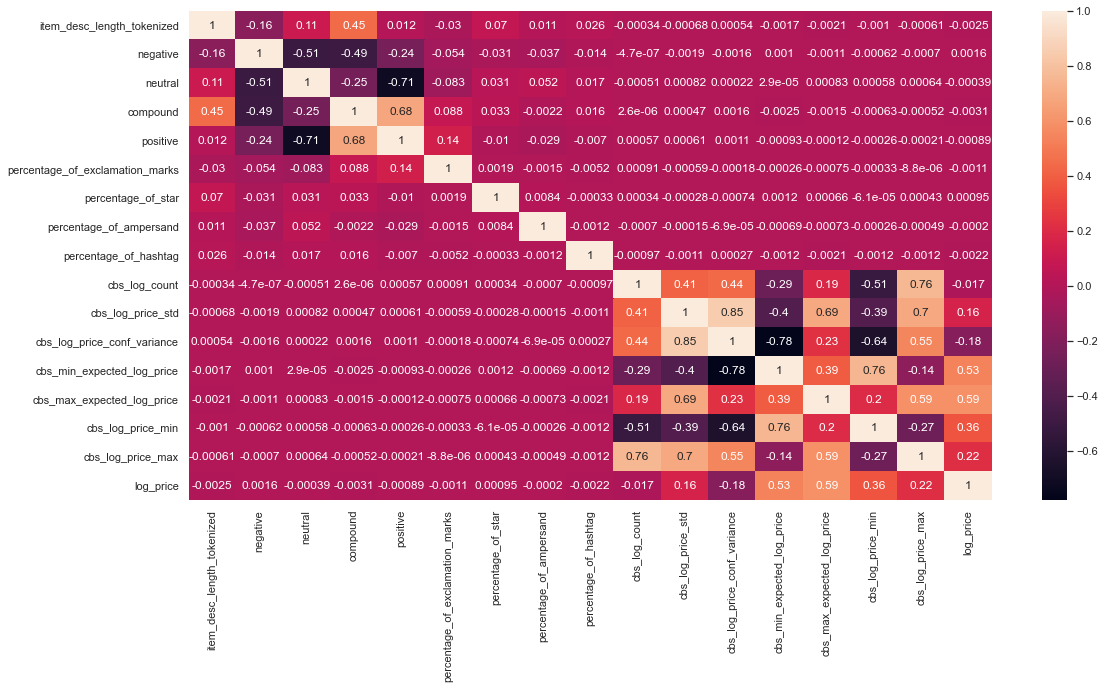

In [53]:
corrMatrix  = df_corr.corr()

plt.figure(figsize = (18,9))
sns.heatmap(corrMatrix, annot=True)
plt.show()

Percentage of hashtag, Percentage of ampersand, Percentage of star, Percentage of exclamation marks
has a low correlation with log price and thus we are dropping.



# X_train and X_test

In [54]:
X_train = scipy.sparse.hstack((X_brand_train,
                               df_train_transform,
                               tfidf_vectorizer_vectors_train,
                               item_shipping_dummies_train,
                               train_name,
                               np.array(df_train_split['negative'])[:,None],
                               np.array(df_train_split['neutral'])[:,None],
                               np.array(df_train_split['compound'])[:,None],
                               np.array(df_train_split['positive'])[:,None]
                              )).tocsr().astype('float32')

X_test = scipy.sparse.hstack((X_brand_test,
                              df_test_transform,
                              tfidf_vectorizer_vectors_test,
                              item_shipping_dummies_test,
                              test_name,
                              np.array(df_test_split['negative'])[:,None],
                              np.array(df_test_split['neutral'])[:,None],
                              np.array(df_test_split['compound'])[:,None],
                              np.array(df_test_split['positive'])[:,None]
                              )).tocsr().astype('float32')

y_train = df_train_split['log_price']
y_test = df_test_split['log_price']

print("X_train Shape is ",X_train.shape)
print("X_test Shape is ",X_test.shape)
print("y_train Shape is ",y_train.shape)
print("y_test Shape is ",y_test.shape)

X_train Shape is  (1111268, 22054)
X_test Shape is  (370384, 22054)
y_train Shape is  (1111268,)
y_test Shape is  (370384,)


In [55]:
print(train_cbs_feats.shape, test_cbs_feats.shape)
print(X_brand_train.shape, X_brand_test.shape)
print(df_train_transform.shape, df_test_transform.shape)
print(tfidf_vectorizer_vectors_train.shape, tfidf_vectorizer_vectors_test.shape)
print(train_name.shape, test_name.shape)

(1111268, 7) (370384, 7)
(1111268, 4455) (370384, 4455)
(1111268, 937) (370384, 937)
(1111268, 5000) (370384, 5000)
(1111268, 11656) (370384, 11656)


In [56]:
from scipy import sparse
import pandas as pd
#Uncomment out to save for the first time. Subsequent times only need to load
sparse.save_npz("X_train.npz", X_train)
sparse.save_npz("X_test.npz", X_test)
y_train.to_pickle("y_train")
y_test.to_pickle("y_test")


#Keep uncommented to load. 
X_train = sparse.load_npz("X_train.npz")
X_test = sparse.load_npz("X_test.npz")

y_train = pd.read_pickle("y_train")
y_test = pd.read_pickle("y_test")
y_test = pd.read_pickle("y_test")

In [57]:
y_train.shape

(1111268,)